In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine 
import missingno as msno
from zipfile import ZipFile
import sys
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import psycopg2


# Extract CSVs into DataFrames

## Customer File

In [3]:
customers_file = "resources/customers.csv"
customers_df = pd.read_csv(customers_file)
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [4]:
#checking duplicate row 
customers_df.duplicated().sum()

0

In [5]:
#checking duplicate row 
customers_df.duplicated(subset=['customer_id']).sum()

0

In [6]:
#checking number of null columns
customers_df.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

<AxesSubplot:>

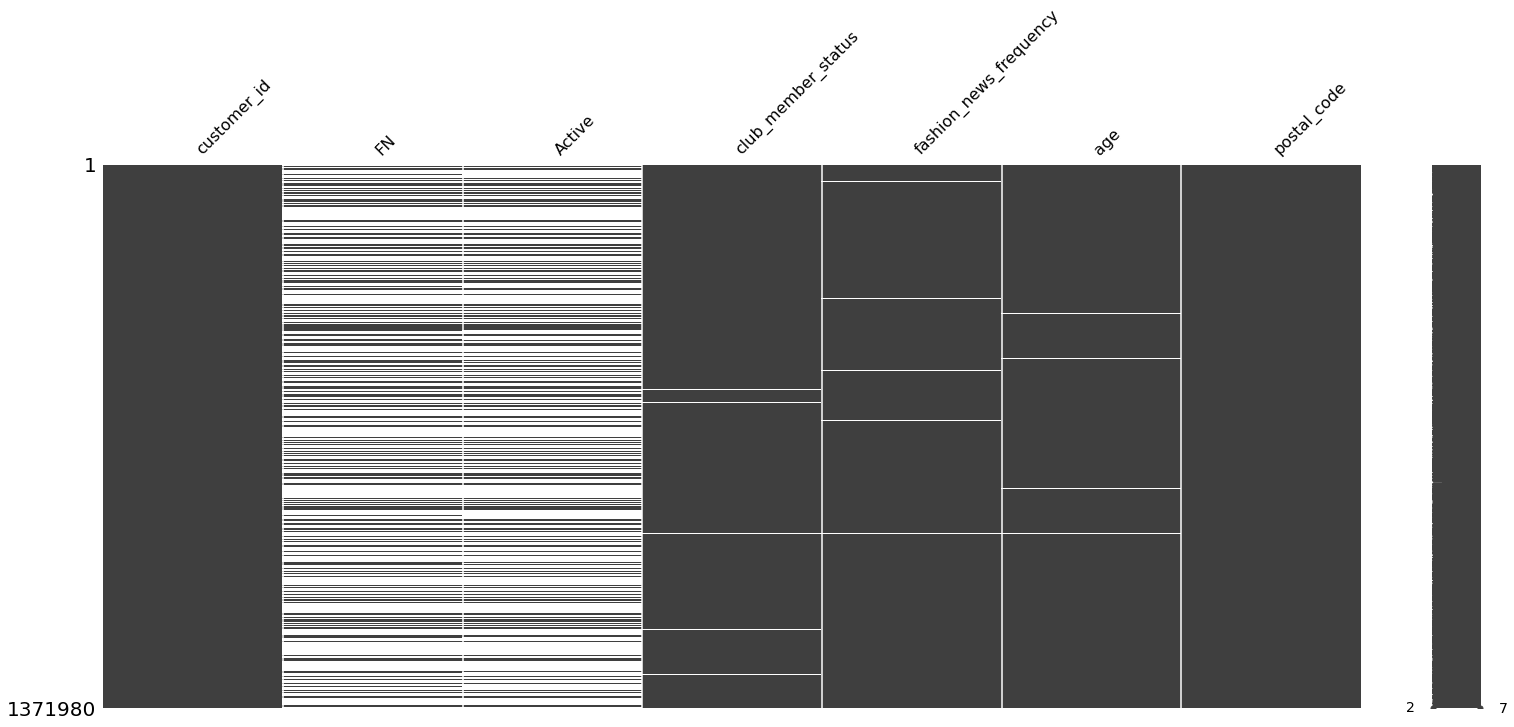

In [7]:
msno.matrix(customers_df)

In [8]:
#converting customer_id to int type
def id_inting(x):
    return int(x[-16:],16)

In [9]:
#converting customer_id to int type
print(f'number of uunique customer_id before converting {customers_df["customer_id"].nunique()}')
customers_df['customer_id']= customers_df['customer_id'].apply(id_inting)
print(f'number of uunique customer_id after converting {customers_df["customer_id"].nunique()}')

number of uunique customer_id before converting 1371980
number of uunique customer_id after converting 1371980


In [10]:
#converting postal_code to int type
print(f'number of uunique postal_code before converting {customers_df["postal_code"].nunique()}')
customers_df['postal_code']= customers_df['postal_code'].apply(id_inting)
print(f'number of uunique postal_code after converting {customers_df["postal_code"].nunique()}')

number of uunique postal_code before converting 352899
number of uunique postal_code after converting 352899


In [11]:
#Fill null value of FN column
print(f"The unique values before imputing in FN column: {customers_df['FN'].unique()}")
customers_df['FN'].fillna(0.0 ,inplace=True)
customers_df["FN"].replace("Not_interested",0.0,inplace=True)
print(f"The unique values after imputing in FN column: {customers_df['FN'].unique()}")

The unique values before imputing in FN column: [nan  1.]
The unique values after imputing in FN column: [0. 1.]


In [12]:
#Fill null value of Active column
print(f"The unique values before imputing in Active column: {customers_df['Active'].unique()}")
customers_df['Active'].fillna(0.0 ,inplace=True)
customers_df["Active"].replace("Not_interested",0.0,inplace=True)
print(f"The unique values after imputing in Active column : {customers_df['Active'].unique()}")

The unique values before imputing in Active column: [nan  1.]
The unique values after imputing in Active column : [0. 1.]


In [13]:
#checking number of null columns again
customers_df.isna().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status         6062
fashion_news_frequency    16009
age                       15861
postal_code                   0
dtype: int64

In [14]:
#checking if we can drop all null rows
(customers_df['fashion_news_frequency'].isna().sum()/len(customers_df))*100

1.1668537442236768

In [15]:
# Drop all null values
customers_df.dropna(axis=0, how='any',inplace=True)

In [16]:
#Fill null value of fashion_news_frequency column
print(f"The unique values before imputing in fashion_news_frequency column: {customers_df['fashion_news_frequency'].unique()}")
customers_df["fashion_news_frequency"].replace("NONE","None",inplace=True)
print(f"The unique values after imputing in fashion_news_frequency column: {customers_df['fashion_news_frequency'].unique()}")

The unique values before imputing in fashion_news_frequency column: ['NONE' 'Regularly' 'Monthly' 'None']
The unique values after imputing in fashion_news_frequency column: ['None' 'Regularly' 'Monthly']


In [17]:
#checking duplicate row 
customers_df.duplicated(subset=['customer_id']).sum()

0

In [18]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338570 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1338570 non-null  uint64 
 1   FN                      1338570 non-null  float64
 2   Active                  1338570 non-null  float64
 3   club_member_status      1338570 non-null  object 
 4   fashion_news_frequency  1338570 non-null  object 
 5   age                     1338570 non-null  float64
 6   postal_code             1338570 non-null  uint64 
dtypes: float64(3), object(2), uint64(2)
memory usage: 81.7+ MB


In [19]:
#Type changing
customers_df=customers_df.astype({'customer_id': 'int32'})
customers_df=customers_df.astype({'postal_code': 'int32'})
customers_df=customers_df.astype({'FN': 'int32'})
customers_df=customers_df.astype({'Active': 'int32'})
customers_df=customers_df.astype({'age': 'int32'})


In [20]:
#drop duplicate customer_id
customers_df.drop_duplicates(subset ="customer_id",
                     keep = 'first', inplace = True)

In [21]:
customers_df.columns=['customer_id', 'fn', 'active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code']

## Transactions File

In [22]:
transactions_file = "resources/transactions_train.csv"
transactions_df = pd.read_csv(transactions_file)
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [23]:
#changing the t_dat column to datetime format
transactions_df["t_dat"]=pd.to_datetime(transactions_df["t_dat"])
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB


In [24]:
#checking number of null columns
transactions_df.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [25]:
#converting customer_id to int type
print(f'number of uunique customer_id before converting {transactions_df["customer_id"].nunique()}')
transactions_df['customer_id']= transactions_df['customer_id'].apply(id_inting)
print(f'number of uunique customer_id after converting {transactions_df["customer_id"].nunique()}')

number of uunique customer_id before converting 1362281
number of uunique customer_id after converting 1362281


In [26]:
#Type changing
transactions_df=transactions_df.astype({'customer_id': 'int32'})



In [27]:
transactions_df.reset_index(inplace=True)
transactions_df = transactions_df.rename(columns = {'index':'transactions_id'})

## Article File

In [28]:
article_file = "resources/articles.csv"
article_df = pd.read_csv(article_file)
#checking number of null columns
article_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [30]:
#checking duplicate row 
article_df.duplicated().sum()


0

In [31]:
#droping the unnecessary column that shows the category numbers
article_df.drop(['product_code', 'product_type_no','graphical_appearance_no','colour_group_code',
'perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no',
'section_no','garment_group_no','detail_desc','perceived_colour_master_name'], axis=1,inplace=True)

In [32]:
article_df.head(2)

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic


In [33]:
#Change the value of some prod_name column
print(f"The unique values before imputing in prod_name column: {article_df['prod_name'].unique()}")
article_df["prod_name"].replace("Strap top (1)","Strap top",inplace=True)
print(f"The unique values after imputing in prod_name column: {article_df['prod_name'].unique()}")

The unique values before imputing in prod_name column: ['Strap top' 'Strap top (1)' 'OP T-shirt (Idro)' ... 'Cartwheel dress'
 'CLAIRE HAIR CLAW' 'Lounge dress']
The unique values after imputing in prod_name column: ['Strap top' 'OP T-shirt (Idro)' '20 den 1p Stockings' ...
 'Cartwheel dress' 'CLAIRE HAIR CLAW' 'Lounge dress']


In [34]:
#checking duplicate row 
article_df.duplicated(subset=['article_id']).sum()

0

## API CVS Files

In [35]:
#reading ApI csv files
women_df = pd.read_csv("outputs/women_article_df.csv")
men_df = pd.read_csv("outputs/men_article_df.csv")
baby_df = pd.read_csv("outputs/baby_article_df.csv")
kids_df = pd.read_csv("outputs/kids_article.csv")

kids_df


,articleCode,title,category,price($)
0,1058174007,2-piece Printed Set,kids_girls_clothing_topstshirts_tshirts,24.99
1,1058174003,2-piece Printed Set,kids_girls_clothing_topstshirts_tshirts,24.99
2,1058174002,2-piece Printed Set,kids_girls_clothing_topstshirts_tshirts,24.99
3,1035221001,2-piece Set,kids_girls_setsoutfits,24.99
4,1021186003,2-piece Cotton Set,kids_boys_setsoutfits,24.99
...,...,...,...,...
3128,1037853001,2-piece Cotton Set,kids_girls_setsoutfits,24.99
3129,840505013,Hooded Jacket,kids_girls_clothing_jumperssweatshirts_hoodies,14.99
3130,758485002,2-pack Sports Tights,kids_girls_sportswear,29.99
3131,943831002,2-piece Set,kids_girls_clothing_jumperssweatshirts_hoodies,24.99


In [36]:
frames = [women_df, men_df, baby_df,kids_df]

API_data = pd.concat(frames)

In [37]:
#dropping category column 
API_data.drop('category',axis=1, inplace=True)
#renaming columns
API_data.columns=["article_id","title","price"]
API_data

,article_id,title,price
0,963087001,Wide-leg Twill Pants,17.99
1,963087016,Wide-leg Twill Pants,17.99
2,939703036,V-neck Blouse,17.99
3,895610022,Dress Pants,34.99
4,751471042,Slacks,19.99
...,...,...,...
3128,1037853001,2-piece Cotton Set,24.99
3129,840505013,Hooded Jacket,14.99
3130,758485002,2-pack Sports Tights,29.99
3131,943831002,2-piece Set,24.99


In [38]:
#drop duplicate value
API_data.drop_duplicates()

,article_id,title,price
0,963087001,Wide-leg Twill Pants,17.99
1,963087016,Wide-leg Twill Pants,17.99
2,939703036,V-neck Blouse,17.99
3,895610022,Dress Pants,34.99
4,751471042,Slacks,19.99
...,...,...,...
3128,1037853001,2-piece Cotton Set,24.99
3129,840505013,Hooded Jacket,14.99
3130,758485002,2-pack Sports Tights,29.99
3131,943831002,2-piece Set,24.99


In [39]:
#checking number of null columns
API_data.isna().sum()

article_id    0
title         0
price         0
dtype: int64

In [40]:
#checking duplicate row 
API_data.duplicated(subset=['article_id']).sum()

38

In [41]:
#drop duplicate customer_id
API_data.drop_duplicates(subset ="article_id",
                     keep = 'first', inplace = True)

### Merging

In [43]:
#merging article_df from Kaggle and concat dataframe from API
kaggle_API_article_df=pd.merge(API_data,article_df,on="article_id",how='inner')

In [44]:
#merging article_df and transaction_df  from Kaggle 
transactions_article_df=pd.merge(transactions_df,article_df,on="article_id",how='inner')

In [46]:
#merging customer_df and transaction_df  from Kaggle 
transactions_customers_df=pd.merge(transactions_df,customers_df,on="customer_id",how='inner')

In [50]:
print(f"so The merging dataframe are too big {len(transactions_customers_df)} that we can't load them to sql so we load tables before mergins and make a sample for the big table.") 

so The merging dataframe are too big 31471679 that we can't load them to sql so we load tables before mergins and make a sample for the big table.


### Connect to local database

In [51]:
rds_connection_string = "postgres:password@localhost:5432/hm_tables"
engine = create_engine(f'postgresql://{rds_connection_string}')

### Check for tables


In [52]:
engine.table_names()

C:\Users\Lales\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  """Entry point for launching an IPython kernel.


['customer', 'article', 'api_data', 'transactions']

### Use pandas to load csv converted DataFrame into database

In [53]:
article_df.to_sql(name='article', con=engine, if_exists='append', index=False)
customers_df.to_sql(name='customer', con=engine, if_exists='append', index=False)
API_data.to_sql(name='api_data', con=engine, if_exists='append', index=False)


In [54]:
#As the transaction_df is too big and can't be loaded to postgresql
transactions_df[:1000000].to_sql(name='transactions', con=engine, if_exists='append', index=False)

### Confirm data has been added by querying the tables


In [55]:
pd.read_sql_query('select * from customer', con=engine).head()

,customer_id,fn,active,club_member_status,fashion_news_frequency,age,postal_code
0,-1612724649,0,0,ACTIVE,None,49,1861910784
1,-1740365574,0,0,ACTIVE,None,25,851193943
2,277996312,0,0,ACTIVE,None,24,-477921060
3,-16268226,0,0,ACTIVE,None,54,975416941
4,-1922717606,1,1,ACTIVE,Regularly,52,1518361373


In [56]:
pd.read_sql_query('select * from article', con=engine).head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top,Vest top,Garment Upper body,Stripe,Off White,Dusty Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [57]:
pd.read_sql_query('select * from api_data', con=engine).head()

,article_id,title,price
0,963087001,Wide-leg Twill Pants,17.99
1,963087016,Wide-leg Twill Pants,17.99
2,939703036,V-neck Blouse,17.99
3,895610022,Dress Pants,34.99
4,751471042,Slacks,19.99


In [58]:
pd.read_sql_query('select * from transactions', con=engine).head()

,transactions_id,customer_id,t_dat,article_id,price,sales_channel_id
0,0,277996312,2018-09-20,663713001,0.050831,2
1,1,277996312,2018-09-20,541518023,0.030492,2
2,2,167857346,2018-09-20,505221004,0.015237,2
3,3,167857346,2018-09-20,685687003,0.016932,2
4,4,167857346,2018-09-20,685687004,0.016932,2
